# Face Recognition Using Eigenfaces
###### Erhan Can Özcan 05/13/2019

In this project, I will design a face recognition system employing the Eigenface approach of Turk and Pentland. While doing this project, I utilized the ORL face database. This database includes 40 subjects with 10 face images per subject. While first five images of each subject are used to extract features in the training, the remaining pictures are separated as test set to measure the performance of the face recognition system. In next sections, you can see the code, first 20 Eigenfaces, reconstructed face image from test set, reconstructed non-face image, and finally the plot showing the performance of the face recognition system. To be able to use the code

In [1]:
#import import_ipynb
import os
path_to_data="/Users/can/Documents/Biometrics/a3/ORL-DATABASE"
path_to_non_human="/Users/can/Documents/Biometrics/a3/non_human.jpeg"
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#%matplotlib inline
import cv2
from read_data_a3 import prepare_train_test
from plot_a3 import plot_eigen_faces,eigen_face_projection,draw_picture_with_n_features
import math
import pandas as pd
from performance_a3 import obtain_new_features,calculate_accuracy
from scipy.spatial import distance_matrix

The code chunk below prepares the training and test set. Each set has 200 pictures, and consists of 40 subjects in total. You can see 2 different people and their one training and test picture below.

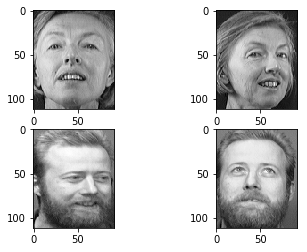

In [2]:
no_of_tr_pictures=200
no_of_test_pictures=200
width=92
height=112
#read data and reshape training test input
np_training_input,np_test_input,np_training_class,np_test_class=prepare_train_test(path_to_data)

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(np_training_input[20,:],cmap="gray")
axarr[0,1].imshow(np_test_input[20,:],cmap="gray")
axarr[1,0].imshow(np_training_input[40,:],cmap="gray")
axarr[1,1].imshow(np_test_input[40,:],cmap="gray")

#plt.imshow(np_training_input[20,],cmap="gray")
#plt.imshow(np_test_input[20,],cmap="gray")
tr_input_row=np_training_input.reshape(no_of_tr_pictures,height*width)
test_input_row=np_test_input.reshape(no_of_test_pictures,height*width)
#plt.imshow(tr_input_row.reshape(200,height,width)[20,],cmap="gray")
#plt.imshow(test_input_row.reshape(200,height,width)[20,],cmap="gray")

Each row of tr_input_row and, test_input_row represents a face.
In next step, we will take transpose of these matrices so that each column will
represent a face. Difference faces are obtained by subtracting the average face from training faces. The eigenvalues and eigenvectors are calculated by using the matrix $A^{T}A$ in order to increase the efficiency(where A represents difference faces). 

In [3]:
tr_input_col=np.transpose(tr_input_row)
test_input_col=np.transpose(test_input_row)

#to calculate average face, we need to calculate average of each row.
average_face=np.mean(tr_input_col,axis=1)
#average_face.reshape(10304,1)

difference_faces=np.transpose(np.array([average_face,]*no_of_tr_pictures))
difference_faces=tr_input_col-difference_faces

aTa=np.matmul(np.transpose(difference_faces),difference_faces)
from numpy import linalg as LA
eig_vals,eig_vecs=LA.eig(aTa)
#each column of eig_vecs is a eigen vector.

U=np.matmul(difference_faces,eig_vecs)
#U is scaled by dividing its length
length_U=LA.norm(U,2,axis=0)
U=U/length_U

## First 20 Eigenfaces
Now, we can generate and visualize the first 20 eigenfaces through using the code chunk below.

Text(0.5,0.98,'Figure1: First 20 Eigenfaces')

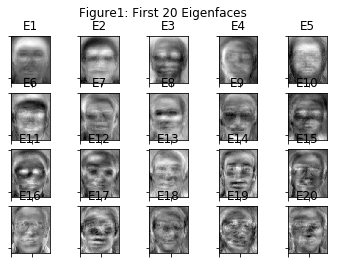

In [4]:
plt_eig_faces, axarr = plt.subplots(4,5)
pic_cntr=0
for m in range(4):
    for n in range(5):
        axarr[m,n].imshow(plot_eigen_faces(U,pic_cntr,width,height),cmap="gray")
        axarr[m,n].set_title("E"+str(pic_cntr+1))
        axarr[m,n].set_xticklabels([])
        axarr[m,n].set_yticklabels([])
        pic_cntr+=1
        
plt_eig_faces.suptitle("Figure1: First 20 Eigenfaces") 

## Reconstruct a Human Face from Test Set

Text(0.5,0.98,'Figure2: Reconstructed Face Image')

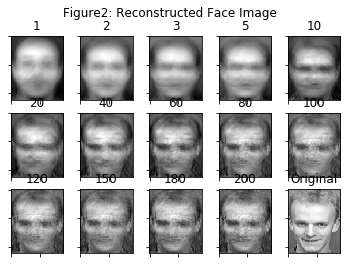

In [5]:
#plot a human face
#selected index ranges from 0 to 199
selected_index=12
selected_image=test_input_col[:,selected_index]

#plt.imshow((np.transpose(selected_image)).reshape(height,width),cmap="gray")

#projected features are new features that are used to describe a new picture.
#in the third question you have to calculate these features for all images.
projected_features=eigen_face_projection(U,selected_image,average_face)

index_list=np.array([1,2,3,5,10,20,40,60,80,100,120,150,180,200])
plt_hum_face, axhum_face = plt.subplots(3,5)
pic_cntr=0
for m in range(3):
    for n in range(5):
        if m==2 and n==4:
            break
        axhum_face[m,n].imshow(draw_picture_with_n_features(projected_features,U,average_face,width,height,index_list[pic_cntr]),cmap="gray")
        axhum_face[m,n].set_title(str(index_list[pic_cntr]))
        axhum_face[m,n].set_xticklabels([])
        axhum_face[m,n].set_yticklabels([])
        pic_cntr+=1
        
        
axhum_face[2,4].imshow((np.transpose(selected_image)).reshape(height,width),cmap="gray")
axhum_face[2,4].set_title("Original")
axhum_face[2,4].set_xticklabels([])
axhum_face[2,4].set_yticklabels([])
        
plt_hum_face.suptitle("Figure2: Reconstructed Face Image")   

One face image from test set is re-constructed by using its eigenface features. Obviously when 40 features are used, the face can be re-constructed with minor differences. It is important to emphasize that even if 200 features are used, the original face cannot be re-constructed since this face image is in the test set.

## Reconstruct a Non-Human Face from Test Set
In this section, a monkey’s face is reconstructed. Since EigenFace method is trained with human faces, it is not capable of reconstructing the monkey’s face.

Text(0.5,0.98,'Figure3: Reconstructed Non-Face Image')

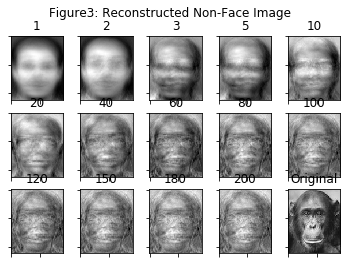

In [6]:
#plot a non-human face
#selected index ranges from 0 to 199

selected_image=cv2.imread(path_to_non_human,cv2.IMREAD_GRAYSCALE)
selected_image=selected_image.reshape(112*92)

#plt.imshow((np.transpose(selected_image)).reshape(height,width),cmap="gray")

#projected features are new features that are used to describe a new picture.
#in the third question you have to calculate these features for all images.
projected_features=eigen_face_projection(U,selected_image,average_face)




index_list=np.array([1,2,3,5,10,20,40,60,80,100,120,150,180,200])
plt_hum_face, axhum_face = plt.subplots(3,5)
pic_cntr=0
for m in range(3):
    for n in range(5):
        if m==2 and n==4:
            break
        axhum_face[m,n].imshow(draw_picture_with_n_features(projected_features,U,average_face,width,height,index_list[pic_cntr]),cmap="gray")
        axhum_face[m,n].set_title(str(index_list[pic_cntr]))
        axhum_face[m,n].set_xticklabels([])
        axhum_face[m,n].set_yticklabels([])
        pic_cntr+=1
        
        
axhum_face[2,4].imshow((np.transpose(selected_image)).reshape(height,width),cmap="gray")
axhum_face[2,4].set_title("Original")
axhum_face[2,4].set_xticklabels([])
axhum_face[2,4].set_yticklabels([])
        
plt_hum_face.suptitle("Figure3: Reconstructed Non-Face Image")  

## Identification Accuracy(for Test Set) vs Dimensionality
We can see that it is possible to obtain images that resembles to original image closely via using first 40 of the projected features. Note that 40 features explain already 84% of the total variance. Therefore, we can represent any face image with these 40 features without losing significant information. 

Text(0.5,0.98,'Figure4: Accuracy vs Dimensionality')

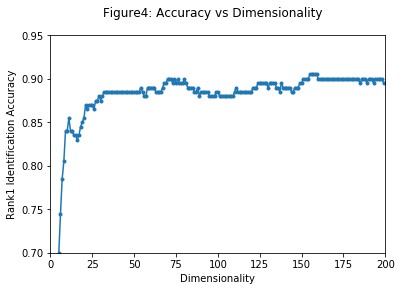

In [7]:
#obtain new features for all pictures

#each row of whole_new_features is a picture. First 200 is training, last 200 is test.
#each column of whole_new_features is newly obtained features.
whole_new_features=obtain_new_features(tr_input_col,test_input_col,U,average_face)

#We will how many features will be utilized. Let's say we want to use 5 features.
#Then, distance matrix will be obtained only using the first 5 columns.

accuracy=calculate_accuracy(whole_new_features,200)

accuracy_list=np.zeros(200)

for cntr in range(200):
    accuracy_list[cntr]=calculate_accuracy(whole_new_features,cntr)
    

f, ax = plt.subplots(1)
ax.set_xlim([0,200])
ax.set_ylim((0.7,0.95))
#f.xlim((0,35))
ax.plot(range(200),accuracy_list,marker='o',label="Accuracy vs Dimensionality",markersize=3)
#f.legend()
ax.set_xlabel("Dimensionality")
ax.set_ylabel("Rank1 Identification Accuracy")
f.suptitle('Figure4: Accuracy vs Dimensionality', fontsize=12)

In [8]:
ind_list=np.array([0,2,4,9,19,24,34,44,64,84,124,164,199])

report_cntr=0
for ind in ind_list:    
    no_eig=ind+1
    Var=sum(eig_vals[:no_eig])/sum(eig_vals)
    accu=accuracy_list[ind]
    if report_cntr==0:
        summary=pd.DataFrame({'NofEigenFaces':no_eig,'VarExplained':Var,'IdentificationRate':accu},index=range(1),columns=list(['NofEigenFaces','VarExplained','IdentificationRate']))
        #real_order=summary.columns
    else:
        tmp=pd.DataFrame({'NofEigenFaces':no_eig,'VarExplained':Var,'IdentificationRate':accu},index=range(1),columns=list(['NofEigenFaces','VarExplained','IdentificationRate']))
        summary=summary.append(tmp)
    report_cntr+=1

summary.index=range(len(ind_list))
print (summary)

    NofEigenFaces  VarExplained  IdentificationRate
0               1      0.188443               0.025
1               3      0.385857               0.320
2               5      0.494721               0.630
3              10      0.620246               0.840
4              20      0.730031               0.850
5              25      0.762909               0.870
6              35      0.810447               0.885
7              45      0.844749               0.885
8              65      0.889226               0.885
9              85      0.921183               0.890
10            125      0.954615               0.895
11            165      0.980645               0.900
12            200      1.000000               0.895


## References
1. Turk, M., Pentland, A.: Eigenfaces for recognition. J. Cognitive Neuroscience 3(1), 71–86 (1991)
2. Lecture Notes. Bogazici University. CMPE58Z Introduction to Biometrics(2019)
3. "The Database of Faces," AT&T Laboratories Cambridge, (2002). [Online]. Available: http://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html.